In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

client_id = 'insert api key here'
client_secret = 'insert secret key here'
auth_url = 'https://api.petfinder.com/v2/oauth2/token'
auth_data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret
}

response = requests.post(auth_url, data=auth_data)
token = response.json().get('access_token')


In [17]:
headers = {
    'Authorization': f'Bearer {token}'
}
params = {
    'location': '84606',
    'distance': 100,
    'limit': 50           
}

# Fetch multiple pages
all_animals = []
page = 1
max_pages = 8

while page <= max_pages:
    params['page'] = page
    response = requests.get('https://api.petfinder.com/v2/animals', headers=headers, params=params)

    if response.status_code == 200:
        animals_data = response.json()['animals']
        
        if not animals_data:
            break

        for animal in animals_data:
            record = {
                'organization_id': animal.get('organization_id'),
                'id': animal.get('id'),
                'species': animal.get('species'),
                'name': animal.get('name'),
                'age': animal.get('age'),
                'breed': animal.get('breeds', {}).get('primary'),
                'mixed': animal.get('breeds', {}).get('mixed'),
                'color': animal.get('colors', {}).get('primary'),
                'fixed': animal.get('attributes', {}).get('spayed_neutered'),
                'house_trained': animal.get('attributes', {}).get('house_trained'),
                'good_with_children': animal.get('environment', {}).get('children'),
                'good_with_dogs': animal.get('environment', {}).get('dogs'),
                'good_with_cats': animal.get('environment', {}).get('cats'),
                'gender': animal.get('gender'),
                'distance': animal.get('distance'),
                'url': animal.get('url')            
            }
            all_animals.append(record)
        
        page += 1 
    else:
        print("Error:", response.status_code, response.json())
        break

animals_df = pd.DataFrame(all_animals)
print(animals_df)


    organization_id        id species             name    age  \
0             UT181  73945365  Rabbit           Bandit  Adult   
1             UT181  73945240  Rabbit             Dale  Adult   
2              UT71  73944309     Cat             Elmo   Baby   
3              UT71  73944310     Cat             Soup   Baby   
4              UT17  73943985     Dog           Sundae  Adult   
..              ...       ...     ...              ...    ...   
395           UT202  73879913     Cat    Pigeon Valdez   Baby   
396           UT202  73879911     Cat  Iggidity Bailey   Baby   
397            UT07  73879402     Dog             Kona  Young   
398           UT189  73879227     Cat       DJ mittens   Baby   
399           UT189  73879225     Cat   Bootsy Clawsby   Baby   

                    breed  mixed              color  fixed  house_trained  \
0                American   True               None   True           True   
1                American   True               None   True       

In [18]:
animals_df

,organization_id,id,species,name,age,breed,mixed,color,fixed,house_trained,good_with_children,good_with_dogs,good_with_cats,gender,distance,url
0,UT181,73945365,Rabbit,Bandit,Adult,American,True,None,True,True,None,None,True,Male,33.3390,https://www.petfinder.com/rabbit/bandit-739453...
1,UT181,73945240,Rabbit,Dale,Adult,American,True,None,True,True,None,None,True,Male,33.3390,https://www.petfinder.com/rabbit/dale-73945240...
2,UT71,73944309,Cat,Elmo,Baby,Domestic Medium Hair,True,None,True,True,None,None,True,Male,31.2310,https://www.petfinder.com/cat/elmo-73944309/ut...
3,UT71,73944310,Cat,Soup,Baby,Domestic Short Hair,True,None,True,True,None,True,True,Male,31.2310,https://www.petfinder.com/cat/soup-73944310/ut...
4,UT17,73943985,Dog,Sundae,Adult,Border Collie,True,None,True,True,True,True,True,Female,33.2255,https://www.petfinder.com/dog/sundae-73943985/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,UT202,73879913,Cat,Pigeon Valdez,Baby,Domestic Short Hair,False,Tortoiseshell,True,False,None,None,None,Female,19.4094,https://www.petfinder.com/cat/pigeon-valdez-73...
396,UT202,73879911,Cat,Iggidity Bailey,Baby,Domestic Short Hair,False,Brown / Chocolate,True,False,None,True,True,Male,19.4094,https://www.petfinder.com/cat/iggidity-bailey-...
397,UT07,73879402,Dog,Kona,Young,German Shepherd Dog,True,None,True,False,None,True,None,Female,34.0997,https://www.petfinder.com/dog/kona-73879402/ut...
398,UT189,73879227,Cat,DJ mittens,Baby,Domestic Short Hair,False,Orange / Red,True,False,None,None,None,Male,8.2912,https://www.petfinder.com/cat/dj-mittens-73879...


In [19]:
# Need organization names
org_ids = animals_df['organization_id'].unique()
org_names = {}

for id in org_ids:
    org_response = requests.get(f'https://api.petfinder.com/v2/organizations/{id}', headers=headers)
    if org_response.status_code == 200:
        org_data = org_response.json().get('organization', {})
        org_names[id] = org_data.get('name')
    else:
        print(f"Error fetching organization {id}")


Error fetching organization UT223


In [20]:
animals_df['organization_name'] = animals_df['organization_id'].map(org_names)
animals_df['organization_name'].unique()

array(['True Hearts Rescue for Healing Paws',
       'Community Animal Welfare Society (CAWS)',
       'Second Chance for Homeless Pets', 'Whiskers',
       'Great Pyrenees Rescue Resources Utah Montana',
       'Humane Society of Utah', 'Davis County Animal Services',
       'Hearts 4 Paws', 'Salt Lake County Animal Services',
       'Utah Valley Animal Rescue, Inc.', 'Nuzzles & Co. Adoption Center',
       'Celestial Zoo Pet Rescue', 'Rescue Rovers Dog Adoptions',
       'Wasatch Wanderers', 'Roosevelt Animal Shelter',
       'Furever Friends Animal Oasis', 'Desiderata Rescue',
       'The Golden Bark Foundation', 'Herding Haven',
       'Humane Society of Northern Utah', 'Throw a Dog a Bone Dog Rescue',
       nan, 'Utah Animal Advocacy Foundation', 'Outreach Pawsabilities',
       'Best Friends Animal Society-Utah', 'Pet Samaritan Fund',
       'Happy Tails at Pegasus', 'Jason Heigl Foundation',
       'Utah Animal Adoption Center', 'Carbon Cat Rescue',
       'Ruff Patch Rescue', 

In [21]:
animals_df.shape

(400, 17)

In [22]:
animals_df.dtypes

organization_id        object
id                      int64
species                object
name                   object
age                    object
breed                  object
mixed                    bool
color                  object
fixed                    bool
house_trained            bool
good_with_children     object
good_with_dogs         object
good_with_cats         object
gender                 object
distance              float64
url                    object
organization_name      object
dtype: object

In [23]:
animals_df.columns

Index(['organization_id', 'id', 'species', 'name', 'age', 'breed', 'mixed',
       'color', 'fixed', 'house_trained', 'good_with_children',
       'good_with_dogs', 'good_with_cats', 'gender', 'distance', 'url',
       'organization_name'],
      dtype='object')

In [24]:
# summary statistics
summary_stats = {
    'Total Animals': len(animals_df),
    'Species Distribution': animals_df['species'].value_counts(),
    'Age Groups': animals_df['age'].value_counts(),
    'Most Common Breeds': animals_df['breed'].value_counts().head(),
    'Gender Distribution': animals_df['gender'].value_counts(normalize=True),
    'Percentage of Animals Fixed': (animals_df['fixed'] == True).mean() * 100,
    'House Trained Percentage': (animals_df['house_trained'] == True).mean() * 100,
    'Most Common Colors': animals_df['color'].value_counts().head(),
    'Organizations Count': animals_df['organization_name'].nunique()
}

print(summary_stats)

{'Total Animals': 400, 'Species Distribution': species
Cat       216
Dog       178
Rabbit      4
Duck        1
Rat         1
Name: count, dtype: int64, 'Age Groups': age
Baby      148
Adult     128
Young     107
Senior     17
Name: count, dtype: int64, 'Most Common Breeds': breed
Domestic Short Hair     164
Domestic Medium Hair     27
Mixed Breed              23
Domestic Long Hair       17
Chihuahua                15
Name: count, dtype: int64, 'Gender Distribution': gender
Female    0.5025
Male      0.4975
Name: proportion, dtype: float64, 'Percentage of Animals Fixed': 77.25, 'House Trained Percentage': 28.999999999999996, 'Most Common Colors': color
Black                               73
Gray / Blue / Silver                44
Brown / Chocolate                   36
White / Cream                       24
Tricolor (Brown, Black, & White)    18
Name: count, dtype: int64, 'Organizations Count': 35}


In [202]:
animals_df

,organization_id,id,species,name,age,breed,mixed,color,fixed,house_trained,good_with_children,good_with_dogs,good_with_cats,gender,distance,url,organization_name
0,UT181,73945365,Rabbit,Bandit,Adult,American,True,None,True,True,None,None,True,Male,33.3390,https://www.petfinder.com/rabbit/bandit-739453...,True Hearts Rescue for Healing Paws
1,UT181,73945240,Rabbit,Dale,Adult,American,True,None,True,True,None,None,True,Male,33.3390,https://www.petfinder.com/rabbit/dale-73945240...,True Hearts Rescue for Healing Paws
2,UT71,73944309,Cat,Elmo,Baby,Domestic Medium Hair,True,None,True,True,None,None,True,Male,31.2310,https://www.petfinder.com/cat/elmo-73944309/ut...,Community Animal Welfare Society (CAWS)
3,UT71,73944310,Cat,Soup,Baby,Domestic Short Hair,True,None,True,True,None,True,True,Male,31.2310,https://www.petfinder.com/cat/soup-73944310/ut...,Community Animal Welfare Society (CAWS)
4,UT17,73943985,Dog,Sundae,Adult,Border Collie,True,None,True,True,True,True,True,Female,33.2255,https://www.petfinder.com/dog/sundae-73943985/...,Second Chance for Homeless Pets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,UT202,73879913,Cat,Pigeon Valdez,Baby,Domestic Short Hair,False,Tortoiseshell,True,False,None,None,None,Female,19.4094,https://www.petfinder.com/cat/pigeon-valdez-73...,Celestial Zoo Pet Rescue
396,UT202,73879911,Cat,Iggidity Bailey,Baby,Domestic Short Hair,False,Brown / Chocolate,True,False,None,True,True,Male,19.4094,https://www.petfinder.com/cat/iggidity-bailey-...,Celestial Zoo Pet Rescue
397,UT07,73879402,Dog,Kona,Young,German Shepherd Dog,True,None,True,False,None,True,None,Female,34.0997,https://www.petfinder.com/dog/kona-73879402/ut...,Salt Lake County Animal Services
398,UT189,73879227,Cat,DJ mittens,Baby,Domestic Short Hair,False,Orange / Red,True,False,None,None,None,Male,8.2912,https://www.petfinder.com/cat/dj-mittens-73879...,"Utah Valley Animal Rescue, Inc."


In [25]:
#EDA

In [200]:
test_df = animals_df.dropna(subset=['good_with_dogs', 'good_with_cats', 'good_with_children']) 

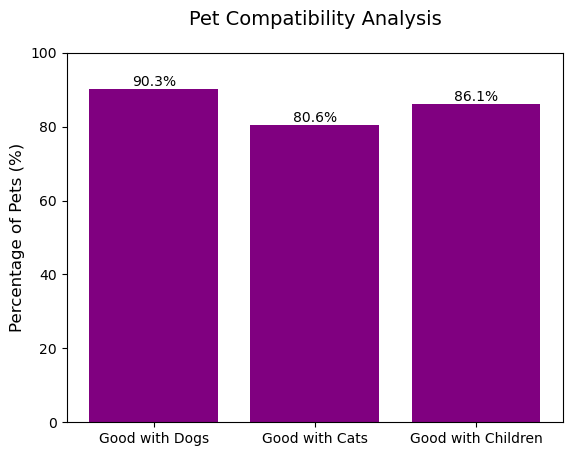

In [201]:
def plot_pet_compatibility(df):
    # Calculate the proportions
    proportions = {
        'Good with Dogs': (df['good_with_dogs'] == True).mean() * 100,
        'Good with Cats': (df['good_with_cats'] == True).mean() * 100,
        'Good with Children': (df['good_with_children'] == True).mean() * 100
    }
    
    plt.figure()

    bars = plt.bar(proportions.keys(), proportions.values(), color = 'purple')
    
    # Customize the plot
    plt.title('Pet Compatibility Analysis', fontsize=14, pad=20)
    plt.ylabel('Percentage of Pets (%)', fontsize=12)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Set y-axis to go from 0 to 100
    plt.ylim(0, 100)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    return plt


plot_pet_compatibility(test_df)
plt.show()

Text(0, 0.5, 'Count of Animals')

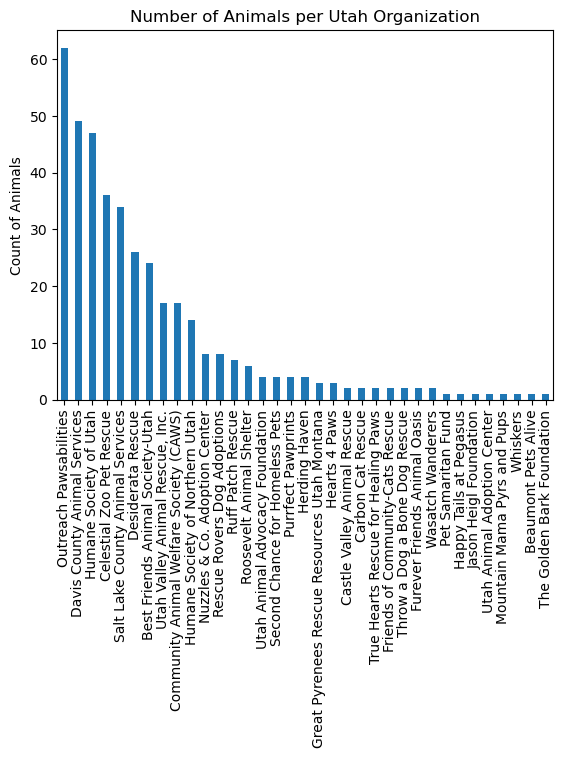

In [33]:
#EDA
import matplotlib.pyplot as plt

count_by_org = animals_df['organization_name'].value_counts()
count_by_org.plot(kind = 'bar')
plt.title("Number of Animals per Utah Organization")
plt.xlabel('')
plt.ylabel("Count of Animals")


In [130]:
# Calculate cat proportions directly
species_df = animals_df[['organization_name', 'species']]

In [131]:
species_df

,organization_name,species
0,True Hearts Rescue for Healing Paws,Rabbit
1,True Hearts Rescue for Healing Paws,Rabbit
2,Community Animal Welfare Society (CAWS),Cat
3,Community Animal Welfare Society (CAWS),Cat
4,Second Chance for Homeless Pets,Dog
...,...,...
395,Celestial Zoo Pet Rescue,Cat
396,Celestial Zoo Pet Rescue,Cat
397,Salt Lake County Animal Services,Dog
398,"Utah Valley Animal Rescue, Inc.",Cat


In [ ]:
# Create a copy to avoid modifying the original DataFrame
org_summary = species_df.copy()

# Group by organization and count the number of animals
org_summary['animal_count'] = org_summary.groupby('organization_name').transform('count')


In [138]:
org_summary

,organization_name,species,animal_count
0,True Hearts Rescue for Healing Paws,Rabbit,2.0
1,True Hearts Rescue for Healing Paws,Rabbit,2.0
2,Community Animal Welfare Society (CAWS),Cat,17.0
3,Community Animal Welfare Society (CAWS),Cat,17.0
4,Second Chance for Homeless Pets,Dog,4.0
...,...,...,...
395,Celestial Zoo Pet Rescue,Cat,36.0
396,Celestial Zoo Pet Rescue,Cat,36.0
397,Salt Lake County Animal Services,Dog,34.0
398,"Utah Valley Animal Rescue, Inc.",Cat,17.0


In [139]:
 # Count the number of cat species for each organization
cat_counts = org_summary[org_summary['species'] == 'Cat'].groupby('organization_name').transform('count')
    

In [149]:
# Calculate the proportion of cat species
org_summary['cat_proportion'] = (cat_counts / org_summary['animal_count']).fillna(0)


In [177]:
# Create a copy to avoid modifying the original DataFrame
org_summary = species_df.copy()

# Group by organization and count the number of animals
org_summary['animal_count'] = org_summary.groupby('organization_name').transform('count')

# Count the number of cat species for each organization
cat_counts = org_summary[org_summary['species'] == 'Cat'].groupby('organization_name')['species'].count()

# Calculate the proportion of cat species
org_summary = org_summary.merge(cat_counts, left_on='organization_name', right_index=True, how='left')
org_summary['cat_proportion'] = (org_summary['species_y'] / org_summary['animal_count']).fillna(0)

# Select only the relevant columns
cat_prop_df = org_summary[['organization_name', 'cat_proportion']].drop_duplicates().dropna().reset_index(drop=True)

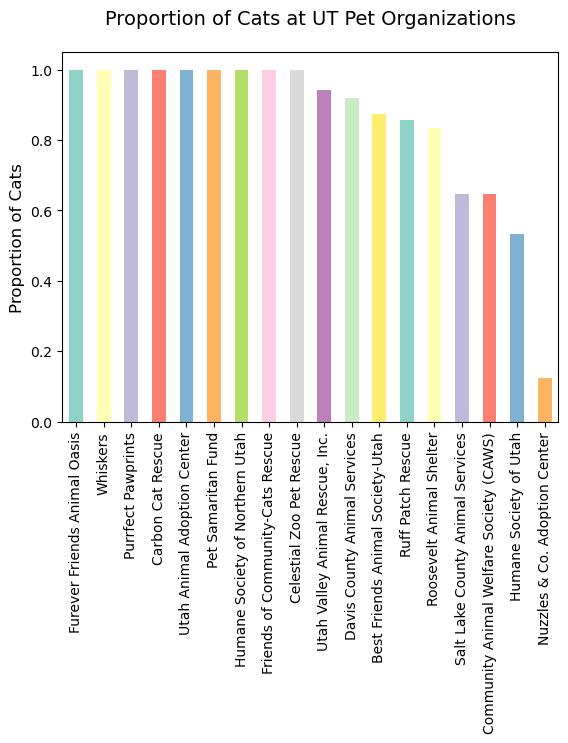

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_prop_df = cat_prop_df[cat_prop_df['cat_proportion'] != 0].sort_values('cat_proportion', ascending=False)
# Create color palette
colors = sns.color_palette("Set3", len(cat_prop_df))

# Transpose and plot
cat_prop_df.set_index('organization_name')['cat_proportion'].plot(kind='bar', color=colors)

# Customize the plot
plt.title('Proportion of Cats at UT Pet Organizations', fontsize=14, pad=20)
plt.ylabel('Proportion of Cats', fontsize=12)
plt.xlabel('')  # Remove x-axis label

plt.show()